In [2]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
from collections import deque
from prettytable import PrettyTable
import time
import matplotlib.pyplot as plt

+--------------+------------+--------------------+--------------------+--------+
|  Algorithm   | Iterations | Execution Time (s) |  Recursive Calls   | Solved |
+--------------+------------+--------------------+--------------------+--------+
|     CSP      |    8772    |       0.0346       |         0          |  Yes   |
| Backtracking |    4209    |       0.8146       | 0.8145582675933838 |  Yes   |
+--------------+------------+--------------------+--------------------+--------+


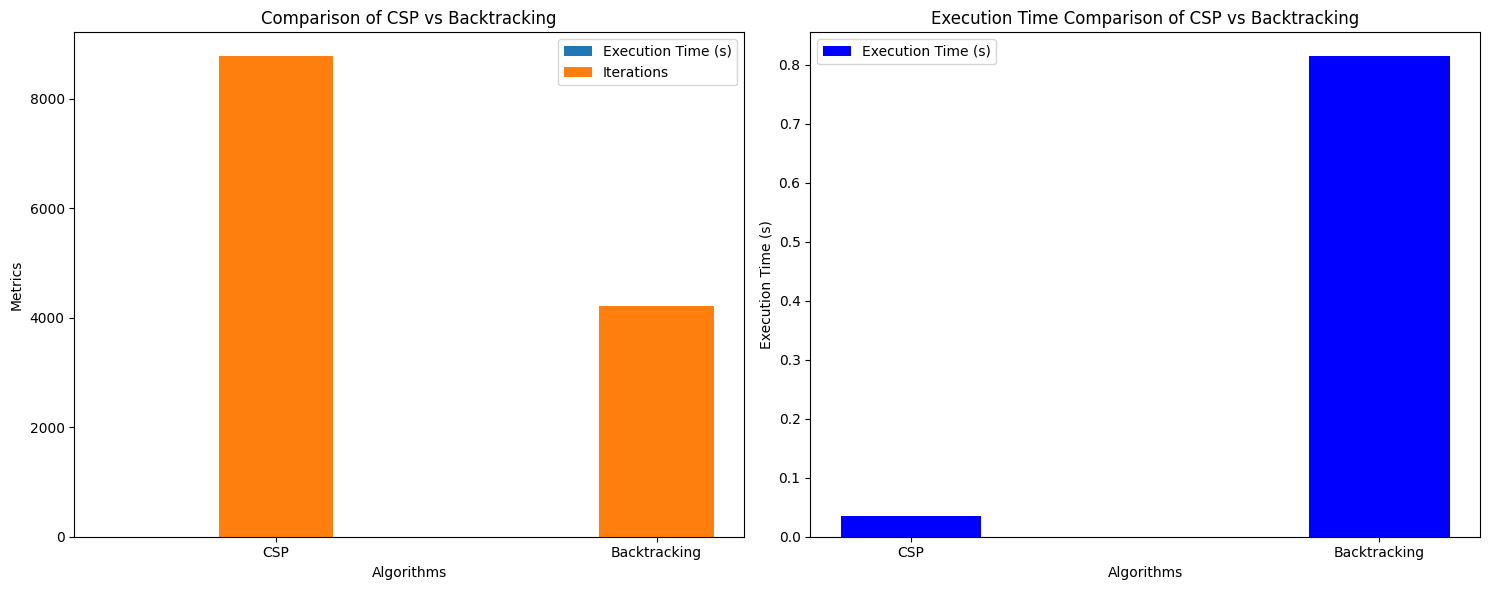

In [35]:
class SudokuSolver:
    def __init__(self, board, size=9):
        self.board = np.array(board)
        self.size = size
        self.subgrid_size = int(np.sqrt(self.size))
        self.iterations = 0
        self.recursive_calls = 0  # Added for recursive call tracking

    def get_neighbors(self, row, col):
        """Get all neighbor cells in the same row, column, or subgrid."""
        neighbors = set()

        # Same row
        for c in range(self.size):
            if c != col:
                neighbors.add((row, c))

        # Same column
        for r in range(self.size):
            if r != row:
                neighbors.add((r, col))

        # Same subgrid
        start_row = (row // self.subgrid_size) * self.subgrid_size
        start_col = (col // self.subgrid_size) * self.subgrid_size
        for r in range(start_row, start_row + self.subgrid_size):
            for c in range(start_col, start_col + self.subgrid_size):
                if (r, c) != (row, col):
                    neighbors.add((r, c))

        return neighbors

    def solve_using_csp(self):
        """Solve the Sudoku using CSP with AC-3."""
        # Initialize domains
        domains = {
            (row, col): {self.board[row, col]} if self.board[row, col] != 0 else set(range(1, self.size + 1))
            for row in range(self.size)
            for col in range(self.size)
        }

        def ac3():
            """AC-3 Algorithm."""
            queue = deque([
                ((row, col), neighbor)
                for row in range(self.size)
                for col in range(self.size)
                if self.board[row, col] == 0
                for neighbor in self.get_neighbors(row, col)
            ])
            while queue:
                (cell, neighbor) = queue.popleft()
                if revise(cell, neighbor):
                    if not domains[cell]:  # If domain becomes empty, failure
                        return False
                    for n in self.get_neighbors(*cell):
                        if n != neighbor:
                            queue.append((n, cell))
                self.iterations += 1
            return True

        def revise(cell, neighbor):
            """Revise the domain of cell for neighbor."""
            revised = False
            to_remove = set()
            for value in domains[cell]:
                if not any(value != v for v in domains[neighbor]):  # No consistent value
                    to_remove.add(value)
            if to_remove:
                domains[cell] -= to_remove
                revised = True
            return revised

        def is_solved():
            """Check if the board is fully assigned."""
            return all(len(domains[cell]) == 1 for cell in domains)

        def select_unassigned_variable():
            """Select the next variable to assign, prioritizing those with the smallest domains."""
            unassigned = [cell for cell in domains if len(domains[cell]) > 1]
            return min(unassigned, key=lambda cell: len(domains[cell]), default=None)

        def backtrack():
            """Recursive backtracking search with AC-3 as preprocessing."""
            self.recursive_calls += 1
            if is_solved():
                return True

            var = select_unassigned_variable()
            if not var:
                return False

            for value in sorted(domains[var]):
                # Try assigning the value
                local_domains = {v: domains[v].copy() for v in domains}  # Copy domains
                domains[var] = {value}

                # Run AC-3 to propagate constraints
                if ac3():
                    if backtrack():  # Recursive step
                        return True

                # Restore domains if failure
                domains.update(local_domains)

            return False

        # Step 1: Apply AC-3 preprocessing
        if not ac3():
            return False

        # Step 2: Solve with backtracking if necessary
        if not is_solved():
            if not backtrack():
                return False

        # Step 3: Assign final values to the board
        for (row, col), values in domains.items():
            self.board[row, col] = next(iter(values))

        return True

    def solve_using_backtracking(self):
        """Solve the Sudoku using standard backtracking."""
        def is_solved():
            """Check if the board is fully assigned."""
            return not any(0 in row for row in self.board)

        def select_unassigned_variable():
            """Selection of next variable assignment, prioritizing empty cells."""
            for r in range(self.size):
                for c in range(self.size):
                    if self.board[r, c] == 0:
                        return r, c
            return None

        def is_valid_assignment(row, col, value):
            """Check if the value can be assigned to the cell."""
            # Check row, column, and subgrid
            if value in self.board[row] or value in self.board[:, col]:
                return False
            subgrid_row = (row // self.subgrid_size) * self.subgrid_size
            subgrid_col = (col // self.subgrid_size) * self.subgrid_size
            if value in self.board[subgrid_row:subgrid_row + self.subgrid_size, subgrid_col:subgrid_col + self.subgrid_size]:
                return False
            return True

        def backtrack():
            """Recursive backtracking."""
            self.recursive_calls += 1
            if is_solved():
                return True

            row, col = select_unassigned_variable()
            if row is None:
                return False

            for value in range(1, self.size + 1):
                if is_valid_assignment(row, col, value):
                    self.board[row, col] = value
                    if backtrack():
                        return True
                    self.board[row, col] = 0

            return False

        start_time = time.time()
        result = backtrack()
        end_time = time.time()

        self.iterations = self.recursive_calls
        self.recursive_calls = end_time - start_time  # Store execution time for backtracking

        return result

def solve_using_metrics(algorithm, board):
    """Solve Sudoku board with specified algorithm and collect metrics."""
    solver = SudokuSolver(board)
    start_time = time.time()

    solved = solver.solve_using_csp() if algorithm == "CSP" else solver.solve_using_backtracking()

    end_time = time.time()

    return {
        "Algorithm": algorithm,
        "Execution Time (s)": round(end_time - start_time, 4),
        "Iterations": solver.iterations,
        "Recursive Calls": solver.recursive_calls,
        "Solved": "Yes" if solved else "No"
    }

def plot_results(metrics_list):
    """Plotting the results in bar graph."""
    algorithms = [metrics["Algorithm"] for metrics in metrics_list]
    execution_times = [metrics["Execution Time (s)"] for metrics in metrics_list]
    iterations = [metrics["Iterations"] for metrics in metrics_list]

    # Bar chart for Execution Time and Iterations
    x = np.arange(len(algorithms))
    width = 0.3

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for Execution Time and Iterations Graph
    ax[0].bar(x - width, execution_times, width, label="Execution Time (s)")
    ax[0].bar(x, iterations, width, label="Iterations")
    ax[0].set_xlabel("Algorithms")
    ax[0].set_ylabel("Metrics")
    ax[0].set_title("Comparison of CSP vs Backtracking")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(algorithms)
    ax[0].legend()
    

    # Plot for Execution Time Comparison Graph
    ax[1].bar(x, execution_times, width, label="Execution Time (s)", color='blue')
    ax[1].set_xlabel("Algorithms")
    ax[1].set_ylabel("Execution Time (s)")
    ax[1].set_title("Execution Time Comparison of CSP vs Backtracking")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(algorithms)
    ax[1].legend()


    plt.tight_layout()
    plt.show()

def main():
    example_board = [
        [5, 3, 0, 0, 7, 0, 0, 0, 0],
        [6, 0, 0, 1, 9, 5, 0, 0, 0],
        [0, 9, 8, 0, 0, 0, 0, 6, 0],
        [8, 0, 0, 0, 6, 0, 0, 0, 3],
        [4, 0, 0, 8, 0, 3, 0, 0, 1],
        [7, 0, 0, 0, 2, 0, 0, 0, 6],
        [0, 6, 0, 0, 0, 0, 2, 8, 0],
        [0, 0, 0, 4, 1, 9, 0, 0, 5],
        [0, 0, 0, 0, 8, 0, 0, 7, 9]
    ]

    metrics_list = []
    for algorithm in ["CSP", "Backtracking"]:
        metrics = solve_using_metrics(algorithm, example_board)
        metrics_list.append(metrics)

    # Display Results in Table
    table = PrettyTable()
    table.field_names = ["Algorithm", "Iterations", "Execution Time (s)", "Recursive Calls", "Solved"]
    for metrics in metrics_list:
        table.add_row([metrics["Algorithm"], metrics["Iterations"], metrics["Execution Time (s)"], metrics["Recursive Calls"], metrics["Solved"]])
    print(table)

    plot_results(metrics_list)

if __name__ == "__main__":
    main()
